In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imagenet

In this notebook we explore the famous [ImageNet](https://www.image-net.org/) dataset, used over the last years to train and benchmark convnets. 

You can download the dataset from https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data

In [21]:
# !kaggle competitions download -c imagenet-object-localization-challenge

In [22]:
import os 
from glob import glob 
from pathlib import Path
import pandas as pd
import random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm

base_path = Path('/fastdata/ILSVRC')
path = Path(base_path / 'Data/CLS-LOC/')

We are provided images for trianing, validation and test. 

In [23]:
splits = os.listdir(path)
splits

['test', 'val', 'train']

Inside the training folder we have 1000 folders, one for each class. Inside each class folder we have the images for that class. Validation and test images are provided in a single folder.

In [24]:
classes = sorted(os.listdir(path/'train'))
assert len(classes) == 1000
val_images = os.listdir(path/'val')

len(classes), len(val_images), len(os.listdir(path/'test'))

(1000, 50000, 100000)

In [25]:
images, labels, cls = [], [], []
for i, c in enumerate(classes):
	this_images = glob(str(path/'train'/c/'*.JPEG'))
	images += this_images
	labels += [i] * len(this_images)
	cls += [c] * len(this_images)
train = pd.DataFrame({'image': images, 'label': labels, 'class': cls})
train

image  label      class
0        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
1        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
2        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
3        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
4        /fastdata/ILSVRC/Data/CLS-LOC/train/n01440764/...      0  n01440764
...                                                    ...    ...        ...
1281162  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281163  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281164  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281165  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141
1281166  /fastdata/ILSVRC/Data/CLS-LOC/train/n15075141/...    999  n15075141

[1281167 rows x 3 columns]

We have a total of 1281167 images for training, 50000 for validation and 100000 for test.

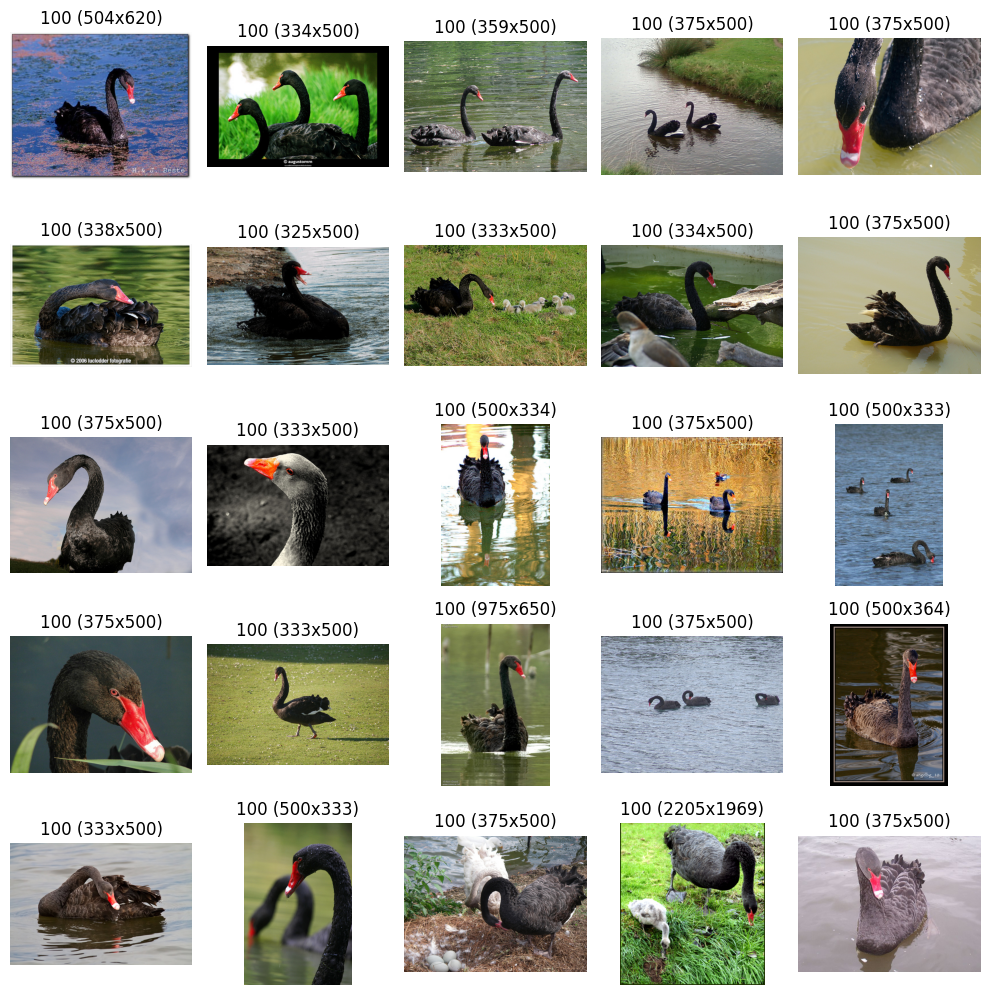

In [26]:
# plot samples

def plot_samples(df, label=100):
	samples = df[df.label == label].sample(25)
	fig = plt.figure(figsize=(10, 10))
	r, c = 5, 5
	for i in range(r * c):
		ax = fig.add_subplot(r, c, i + 1)
		img = plt.imread(samples.iloc[i]['image'])
		plt.imshow(img)
		plt.axis('off')
		h, w = img.shape[:2]
		plt.title(f'{samples.iloc[i]["label"]} ({h}x{w})')
	plt.tight_layout()
	plt.show()

plot_samples(train)

Images can have different resolutions. 

Validation labels can be extracted from the annotation files.

In [27]:
val_annotations = glob(str(base_path/'Annotations/CLS-LOC/val/*.xml'))
assert len(val_annotations) == len(val_images)

In [28]:
val_images, val_labels, val_cls = [], [], []
for ann in tqdm(val_annotations):
    # read xml
	tree = ET.parse(ann)
	root = tree.getroot()
	cls = root.findall('object')[0].find('name').text
	val_cls.append(cls)
	val_labels.append(classes.index(cls))
	val_images.append(path/'val'/f'{ann.split("/")[-1].split(".")[0]}.JPEG')

val = pd.DataFrame({'image': val_images, 'label': val_labels, 'class': val_cls})
val

100%|██████████| 50000/50000 [00:07<00:00, 6372.66it/s]


image  label      class
0      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    796  n04229816
1      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    936  n07714571
2      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    712  n03920288
3      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    202  n02098105
4      /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    419  n02786058
...                                                  ...    ...        ...
49995  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    379  n02492660
49996  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    787  n04192698
49997  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    387  n02509815
49998  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...      7  n01514668
49999  /fastdata/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_v...    669  n03788365

[50000 rows x 3 columns]

In [29]:
assert len(val.label.unique()) == len(classes)

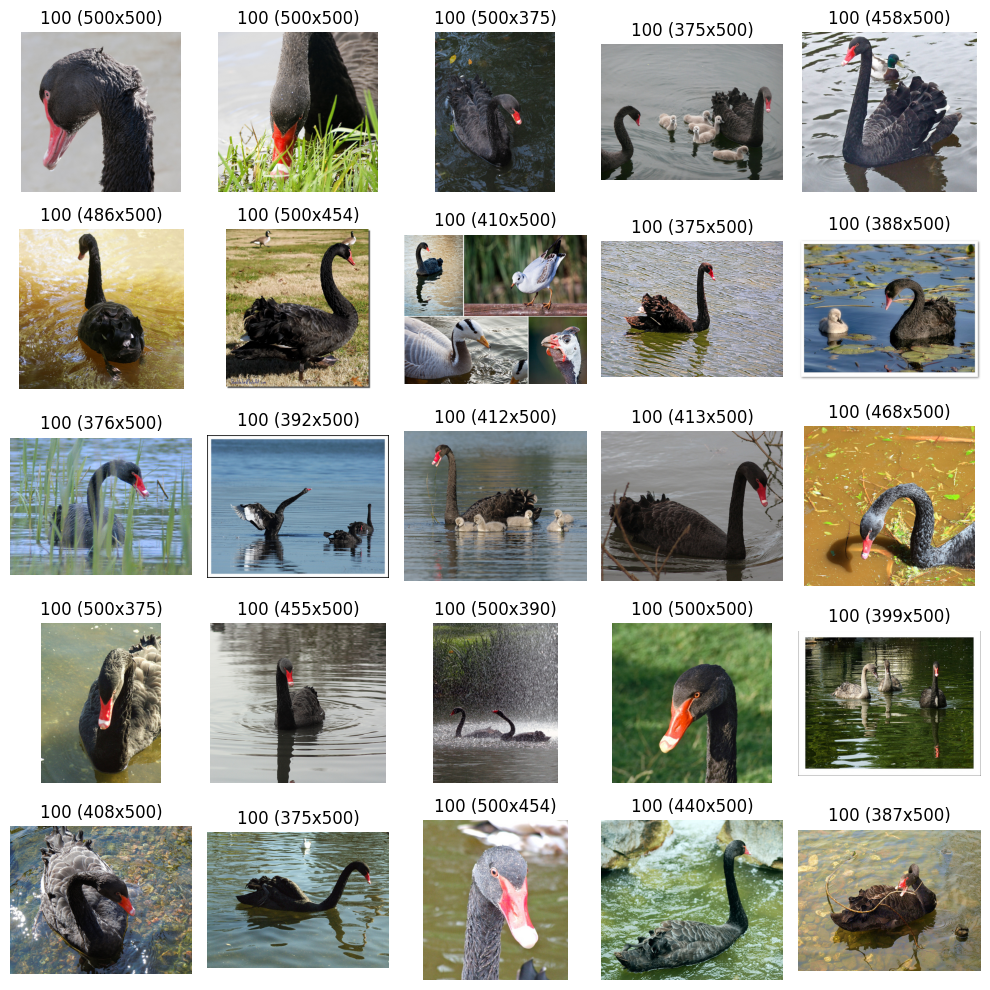

In [30]:
plot_samples(val)

Some models are trained on scaled versions of these images. To accelerate training we can resize them in advance, for example resizing the smallest side to 256 pixels and then take a center crop of size 256x256 and save them in a new directory.

In [12]:
from PIL import Image

def resize_and_crop(path, size=256):
	img = Image.open(path)
	w, h = img.size
	ar = w / h
	if ar > 1:
		img = img.resize((int(size * ar), size), Image.BILINEAR)
		w, h = img.size
		return img.crop((w//2 - size//2, 0, w//2 + size//2, size))
	img = img.resize((size, int(size / ar)), Image.BILINEAR)
	w, h = img.size
	return img.crop((0, h//2 - size//2, size, h//2 + size//2))	

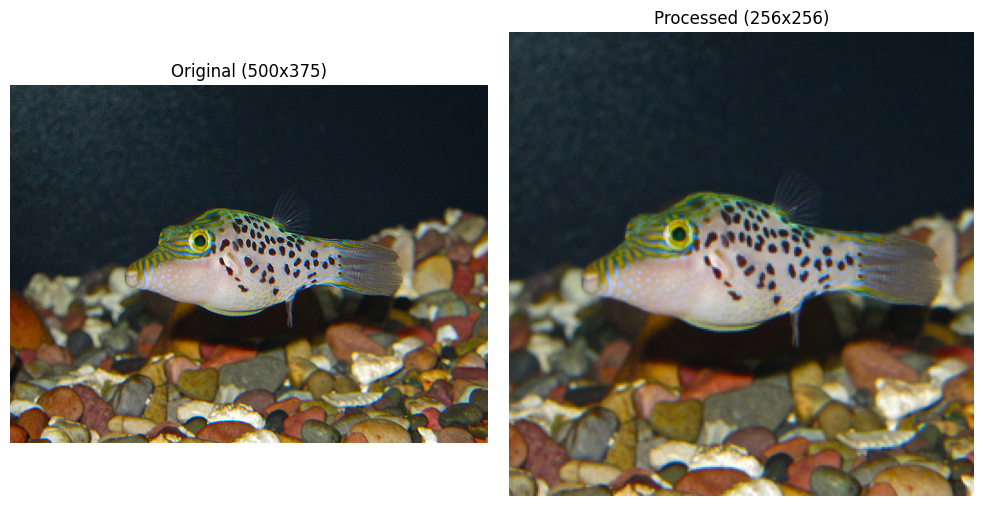

In [13]:
sample = train.sample(1).iloc[0].image
img = resize_and_crop(sample)
img0 = Image.open(sample)

# plot both images side by side 

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(img0)
plt.axis('off')
h,w = img0.size
plt.title(f'Original ({h}x{w})')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off')
h, w = img.size
plt.title(f'Processed ({h}x{w})')
plt.tight_layout()
plt.show()

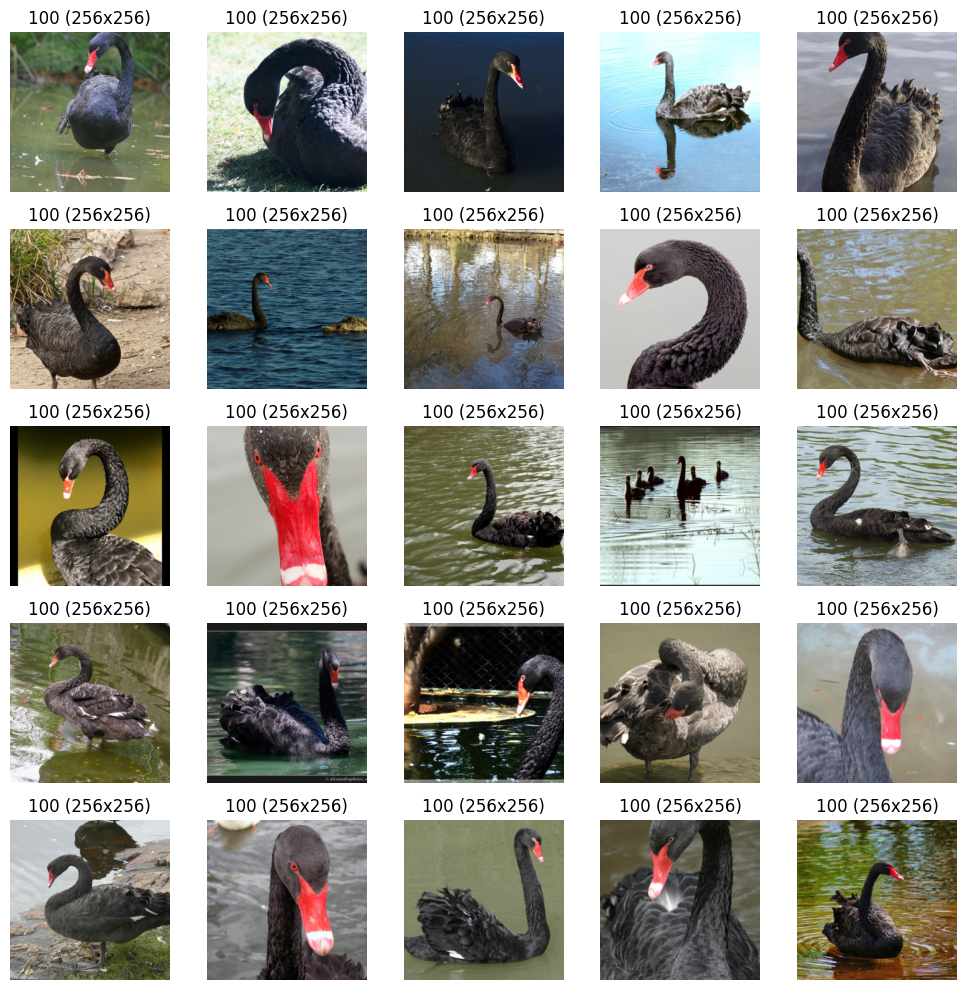

In [14]:
def plot_samples_resized(df, label=100):
	samples = df[df.label == label].sample(25)
	# samples = df.sample(25)
	fig = plt.figure(figsize=(10, 10))
	r, c = 5, 5
	for i in range(r * c):
		ax = fig.add_subplot(r, c, i + 1)
		img = resize_and_crop(samples.iloc[i]['image'])
		plt.imshow(img)
		plt.axis('off')
		h, w = img.size
		plt.title(f'{samples.iloc[i]["label"]} ({h}x{w})')
	plt.tight_layout()
	plt.show()

plot_samples_resized(train)

You can see an example script on how to process the dataset [here](convnets/datasets/imagenet.py). After running it you should have the images ready on the destination folder. If you plan to use the original sizes, you should run it also in order to prepare the data in the way expected from the training scripts in `convents` (just don't pass any argument for the size parameter).

In [15]:
# from convnets.datasets.imagenet import process

# process(base_path = 'data/ILSVRC', dst_path = 'data/imagenet256', size=256) 	# resize images so the smallest side is 256 and keep aspect ratio
# process(base_path = 'data/ILSVRC', dst_path = 'data/imagenet') 				# keep original resolution

In [48]:
# path = Path('/fastdata/imagenet256')
path = Path('/fastdata/imagenet')

splits = os.listdir(path)
splits

['test', 'val', 'train']

train/val splits contain 1000 folders with all the images for that class. The test folder contains all the test images.

In [49]:
classes = sorted(os.listdir(path/'train'))
assert len(classes) == 1000
assert len(classes) == len(os.listdir(path/'val'))

len(classes)

1000

In [50]:
len(os.listdir(path/'test'))

100000

In [51]:
images, labels, cls = [], [], []
for i, c in enumerate(classes):
	this_images = glob(str(path/'train'/c/'*.JPEG'))
	images += this_images
	labels += [i] * len(this_images)
	cls += [c] * len(this_images)
train = pd.DataFrame({'image': images, 'label': labels, 'class': cls})
train

image  label      class
0        /fastdata/imagenet/train/n01440764/n01440764_4...      0  n01440764
1        /fastdata/imagenet/train/n01440764/n01440764_1...      0  n01440764
2        /fastdata/imagenet/train/n01440764/n01440764_3...      0  n01440764
3        /fastdata/imagenet/train/n01440764/n01440764_1...      0  n01440764
4        /fastdata/imagenet/train/n01440764/n01440764_2...      0  n01440764
...                                                    ...    ...        ...
1281162  /fastdata/imagenet/train/n15075141/n15075141_3...    999  n15075141
1281163  /fastdata/imagenet/train/n15075141/n15075141_4...    999  n15075141
1281164  /fastdata/imagenet/train/n15075141/n15075141_2...    999  n15075141
1281165  /fastdata/imagenet/train/n15075141/n15075141_2...    999  n15075141
1281166  /fastdata/imagenet/train/n15075141/n15075141_4...    999  n15075141

[1281167 rows x 3 columns]

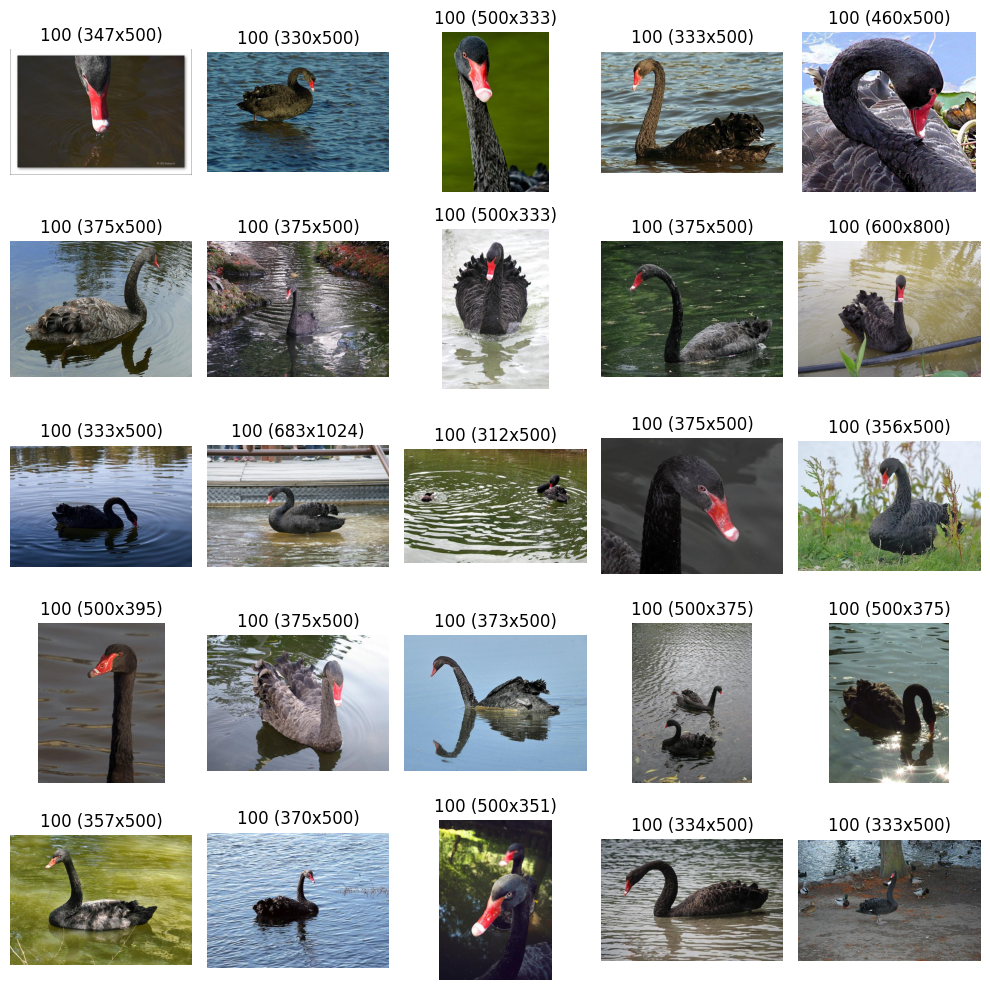

In [52]:
plot_samples(train)

Compute statistics for the dataset.

In [53]:
# from convnets.datasets.imagenet import compute_stats

# mean, std = compute_stats(train.image.values)
# mean, std

Train a model!

In [54]:
from convnets.train import fit 
import pandas as pd
import torch
from torch.utils.data import DataLoader
from convnets.train import seed_everything
import torchvision
import albumentations as A
from convnets.datasets import ImageNet
from convnets.metrics import accuracy

seed_everything()

train_trans = A.Compose([
    A.SmallestMaxSize(list(range(256, 481))), # sacale augmentation
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.RGBShift()
])

val_trans = A.Compose([
    A.SmallestMaxSize(224),
    A.CenterCrop(224, 224)
])

dataloaders  =  {
    'train': DataLoader(ImageNet(path, 'train', train_trans), batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(ImageNet(path, 'val', val_trans), batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

model = torchvision.models.resnet18(weights=False)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()
metrics = {'acc': accuracy}

hist = fit(model, dataloaders, optimizer, criterion, metrics, max_epochs=5, device='cuda', after_epoch_log=False, limit_train_batches=100)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdd0408a050>
Traceback (most recent call last):
  File "/home/juan/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/home/juan/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1444, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyError: "None of [Index(['error', 'val_error'], dtype='object')] are in the [columns]"

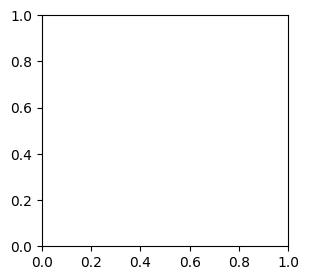

In [55]:
df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()